In [1]:
import math
import matplotlib as mpl
import matplotlib.pylab as plt
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook
import numpy as np
import palettable

import pic_information
from cori_3d import div0, find_nearest
from json_functions import read_data_from_json

plt.style.use("seaborn-deep")
mpl.rc('text', usetex=True)
mpl.rc('font', **{'family': 'sans-serif'})
mpl.rcParams['text.latex.preamble'] = \
[r"\usepackage{amsmath, bm}",
 r"\DeclareMathAlphabet{\mathsfit}{\encodingdefault}{\sfdefault}{m}{sl}",
 r"\SetMathAlphabet{\mathsfit}{bold}{\encodingdefault}{\sfdefault}{bx}{sl}",
 r"\newcommand{\tensorsym}[1]{\bm{\mathsfit{#1}}}"]
COLORS = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

/usr/projects/particle/xiaocanli/xlipy/xlipy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


#### Get the PIC simulation information

In [2]:
pic_run = "3D-Lx150-bg0.2-150ppc-2048KNL"
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/Cori_runs/' + pic_run + '/'
tframe = 20
tstart = 0
tend = 40
nframes = tend - tstart + 1
picinfo_fname = '../data/pic_info/pic_info_' + pic_run + '.json'
pic_info = read_data_from_json(picinfo_fname)
nx, ny, nz = pic_info.nx, pic_info.ny, pic_info.nz
xdi = pic_info.x_di
zdi = pic_info.z_di
xdi_smooth = xdi[::2]
zdi_smooth = zdi[::2]
xmin, xmax = xdi[0], xdi[-1]
zmin, zmax = zdi[0], zdi[-1]

Reading ../data/pic_info/pic_info_3D-Lx150-bg0.2-150ppc-2048KNL.json


In [3]:
species = 'e'
pmass = 1 if species == 'e' else pic_info.mime
vth = pic_info.vthe if species == 'e' else pic_info.vthi
gama = 1.0 / math.sqrt(1.0 - 3 * vth**2)
eth = (gama - 1) * pmass

# Electric Field

In [4]:
def read_efield(tframe):
    """Read electric field at one time frame
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/ex_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ey = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ez_" + str(tindex) + ".gda"
    ez = np.fromfile(fname, dtype=np.float32)
    abse = np.sqrt(ex**2 + ey**2 + ez**2)
    abse1 = abse.reshape((nz//2, ny//2, nx//2))
    return abse1

In [5]:
abse1 = read_efield(10)
abse2 = read_efield(20)

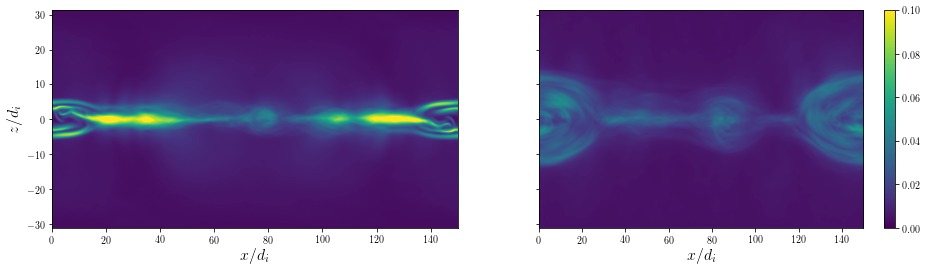

In [6]:
emin, emax = 0.0, 0.1
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,4))
img1 = ax1.imshow(np.mean(abse1, axis=1), vmin=emin, vmax=emax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
img2 = ax2.imshow(np.mean(abse2, axis=1), vmin=emin, vmax=emax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
lx1 = ax1.set_xlabel(r'$x/d_i$', fontsize=16)
ly1 = ax1.set_ylabel(r'$z/d_i$', fontsize=16)
lx2 = ax2.set_xlabel(r'$x/d_i$', fontsize=16)
cbar = fig.colorbar(img2, ax=ax2)

# Current Density

In [7]:
def read_absj(tframe):
    """Read current density at one time frame
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/absJ_" + str(tindex) + ".gda"
    absJ = np.fromfile(fname, dtype=np.float32)
    absJ1 = absJ.reshape((nz//2, ny//2, nx//2))
    return absJ1

In [8]:
absJ1 = read_absj(10)
absJ2 = read_absj(20)

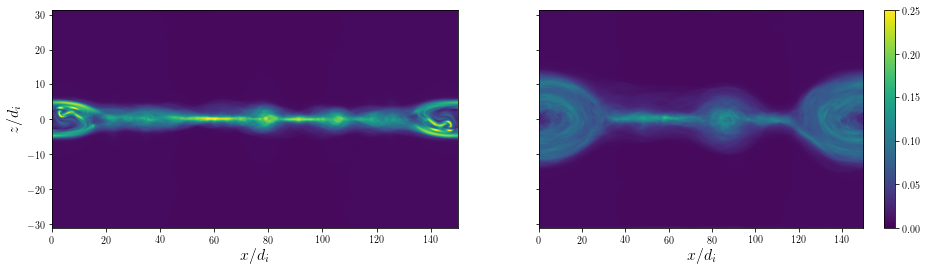

In [9]:
jmin, jmax = 0.0, 0.25
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,4))
img1 = ax1.imshow(np.mean(absJ1, axis=1), vmin=jmin, vmax=jmax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
img2 = ax2.imshow(np.mean(absJ2, axis=1), vmin=jmin, vmax=jmax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
lx1 = ax1.set_xlabel(r'$x/d_i$', fontsize=16)
ly1 = ax1.set_ylabel(r'$z/d_i$', fontsize=16)
lx2 = ax2.set_xlabel(r'$x/d_i$', fontsize=16)
cbar = fig.colorbar(img2, ax=ax2)

# $J\cdot E$, where $J$ is the total current density

In [10]:
def get_jdote(tframe):
    """Get plasma energization j.E
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/jx_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ex_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote = jx * ex
    fname = pic_run_dir + "data-smooth/jy_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote += jx * ex
    fname = pic_run_dir + "data-smooth/jz_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ez_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote += jx * ex
    jdote1 = jdote.reshape((nz//2, ny//2, nx//2))
    return jdote1

In [11]:
jdote1 = get_jdote(10)
jdote2 = get_jdote(20)
jdote3 = get_jdote(30)

In [12]:
jdote1_x = np.sum(np.mean(jdote1, axis=1), axis=0)
jdote2_x = np.sum(np.mean(jdote2, axis=1), axis=0)
jdote3_x = np.sum(np.mean(jdote3, axis=1), axis=0)

In [13]:
def plot_jdote(axs, jdote1, jdote1_x):
    """Plot jdote for one time frame
    """
    jemin, jemax = -0.001, 0.001
    img1 = axs[0].imshow(np.mean(jdote1, axis=1), vmin=jemin, vmax=jemax,
                         extent=[xmin, xmax, zmin, zmax],
                         cmap=plt.cm.seismic, aspect='auto',
                         origin='lower', interpolation='bicubic')
    img1 = axs[1].imshow(np.mean(jdote1, axis=0), vmin=jemin, vmax=jemax,
                         extent=[xmin, xmax, zmin, zmax],
                         cmap=plt.cm.seismic, aspect='auto',
                         origin='lower', interpolation='bicubic')
    p1, = axs[2].plot(xdi_smooth, jdote1_x)
    p2, = axs[2].plot([xmin, xmax], [0, 0])
    lim1 = axs[2].set_xlim([xmin, xmax])

Text(0,0.5,'$y/d_i$')

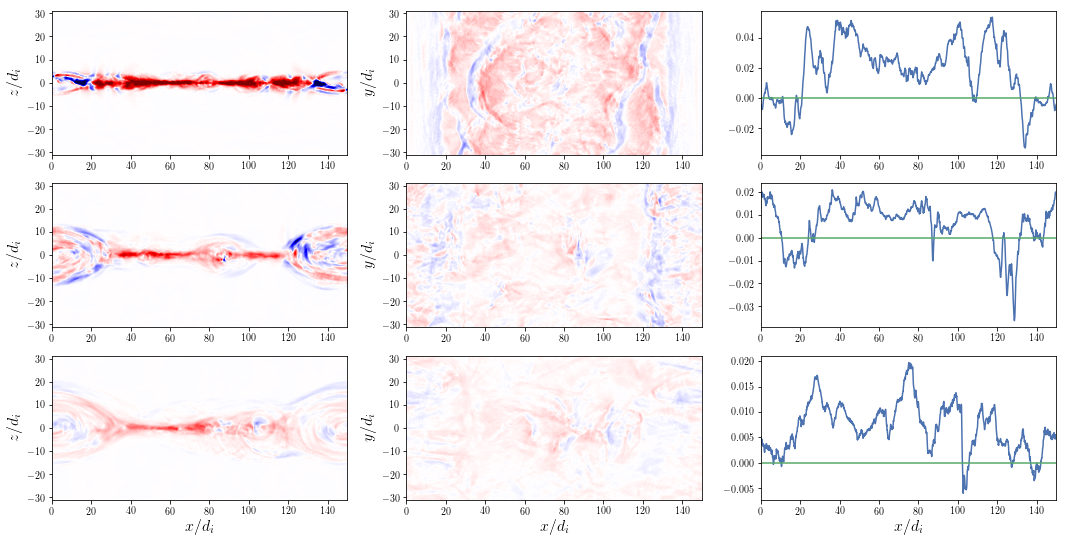

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(18,9))
plot_jdote(axs[0], jdote1, jdote1_x)
plot_jdote(axs[1], jdote2, jdote2_x)
plot_jdote(axs[2], jdote3, jdote3_x)
axs[2, 0].set_xlabel(r'$x/d_i$', fontsize=16)
axs[2, 1].set_xlabel(r'$x/d_i$', fontsize=16)
axs[2, 2].set_xlabel(r'$x/d_i$', fontsize=16)
axs[0, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[1, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[2, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[0, 1].set_ylabel(r'$y/d_i$', fontsize=16)
axs[1, 1].set_ylabel(r'$y/d_i$', fontsize=16)
axs[2, 1].set_ylabel(r'$y/d_i$', fontsize=16)

# The distribution of electric field

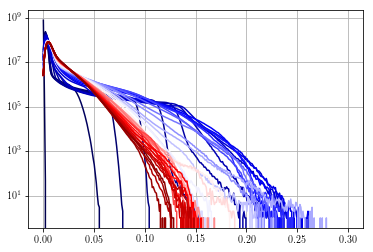

In [15]:
fdir = '../data/cori_3d/abse_dist/' + pic_run + '/'
nacc = np.zeros(nframes)
tframes = range(tstart, tend + 1)
es = 0.05
for tframe in range(tstart, tend + 1):
    fname = fdir + "abse_dist_" + str(tframe) + ".dat"
    earray = np.fromfile(fname)
    nbins = earray.shape[0] // 2
    ebins = earray[:nbins]
    edist = earray[nbins:]
    color = plt.cm.seismic((tframe - tstart)/float(nframes), 1)
    plt.semilogy(ebins, edist, color=color)
    nacc[tframe - tstart] = np.sum(edist[ebins > es])
plt.grid(True)

In [16]:
species = 'e'
if species == 'e':
    dkene = pic_info.dkene_e
else:
    dkene = pic_info.dkene_i

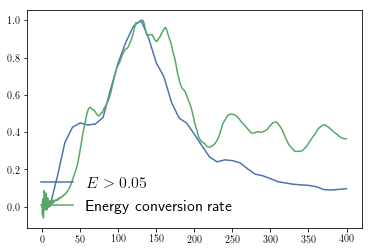

In [17]:
tfields = pic_info.tfields
tenergy = pic_info.tenergy
nacc_norm = nacc / nacc.max()
dkene_norm = dkene / dkene.max()
plt.plot(tfields, nacc_norm, label='$E>' + str(es) + '$')
plt.plot(tenergy, dkene_norm, label='Energy conversion rate')
plt.legend(loc=3, prop={'size': 16}, ncol=1,
          shadow=False, fancybox=False, frameon=False)

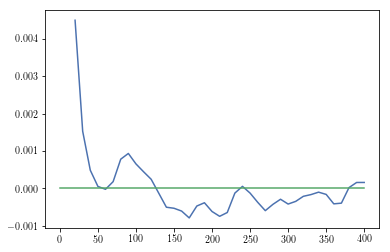

In [18]:
dtf = pic_info.dt_fields * pic_info.dtwpe / pic_info.dtwci
plt.plot(tfields[2:], np.gradient(nacc[2:], dtf)/nacc[2:])
plt.plot([tfields[0], tfields[-1]], [0, 0])

# Particle number density

In [19]:
tframe = 10
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne1 = ne.reshape((nz//2, ny//2, nx//2))

tframe = 20
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne2 = ne.reshape((nz//2, ny//2, nx//2))

tframe = 30
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne3 = ne.reshape((nz//2, ny//2, nx//2))

In [20]:
nx2, ny2, nz2 = nz//2, ny//2, nx//2
ne1_x = np.sum(np.sum(ne1[nz2//4:nz2*3//4], axis=0), axis=0)
ne2_x = np.sum(np.sum(ne2[nz2//4:nz2*3//4], axis=0), axis=0)
ne3_x = np.sum(np.sum(ne3[nz2//4:nz2*3//4], axis=0), axis=0)

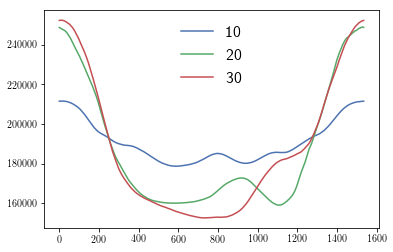

In [21]:
plt.plot(ne1_x, label='10')
plt.plot(ne2_x, label='20')
plt.plot(ne3_x, label='30')
plt.legend(loc=9, prop={'size': 16}, ncol=1,
          shadow=False, fancybox=False, frameon=False)

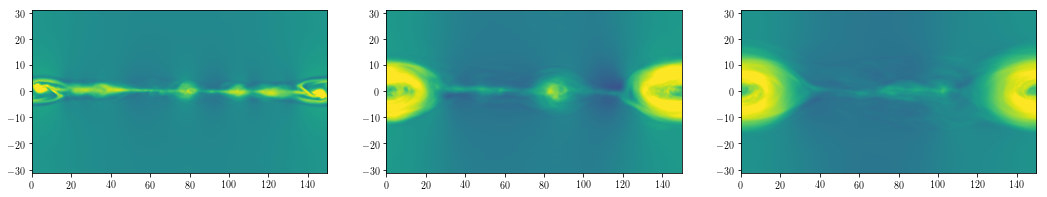

In [22]:
nmin, nmax = 0, 2
fig, axs = plt.subplots(1, 3, figsize=(18,3))
img1 = axs[0].imshow(np.mean(ne1, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')
img2 = axs[1].imshow(np.mean(ne2, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')
img3 = axs[2].imshow(np.mean(ne3, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')

# High-energy particle density

In [23]:
tframe = 10
tindex = pic_info.particle_interval * tframe
ne1_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne1_high += ne.reshape((nz//4, ny//4, nx//4))
    
tframe = 15
tindex = pic_info.particle_interval * tframe
ne2_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne2_high += ne.reshape((nz//4, ny//4, nx//4))
    
tframe = 20
tindex = pic_info.particle_interval * tframe
ne3_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne3_high += ne.reshape((nz//4, ny//4, nx//4))

In [24]:
ne1_high_x = np.sum(np.sum(ne1_high, axis=0), axis=0)
ne2_high_x = np.sum(np.sum(ne2_high, axis=0), axis=0)
ne3_high_x = np.sum(np.sum(ne3_high, axis=0), axis=0)

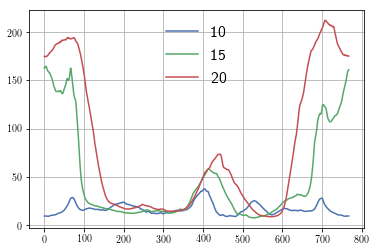

In [25]:
plt.plot(ne1_high_x, label='10')
plt.plot(ne2_high_x, label='15')
plt.plot(ne3_high_x, label='20')
plt.legend(loc=9, prop={'size': 16}, ncol=1,
          shadow=False, fancybox=False, frameon=False)
plt.grid(True)

In [26]:
xth = 100
ne1_high_xb = np.sum(ne1_high_x) - np.sum(ne1_high_x[xth:-xth])
ne2_high_xb = np.sum(ne2_high_x) - np.sum(ne2_high_x[xth:-xth])
ne3_high_xb = np.sum(ne3_high_x) - np.sum(ne3_high_x[xth:-xth])
print(ne1_high_xb, ne2_high_xb, ne3_high_xb)

3202.091403641076 24406.069501124686 37795.2145566738


In [27]:
nhigh_min = 0
nhigh_max = 0.005

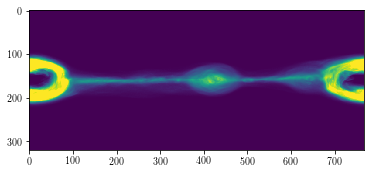

In [28]:
plt.imshow(np.mean(ne2_high, axis=1),
           vmin=nhigh_min, vmax=nhigh_max,
           cmap=plt.cm.viridis)

In [29]:
ne1_high_z = np.sum(np.sum(ne1_high, axis=2), axis=1)
ne2_high_z = np.sum(np.sum(ne2_high, axis=2), axis=1)
ne3_high_z = np.sum(np.sum(ne3_high, axis=2), axis=1)

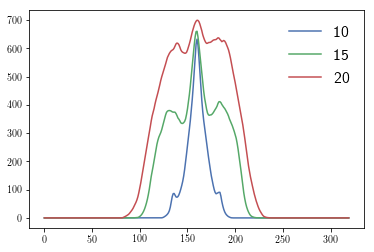

In [30]:
plt.plot(ne1_high_z, label='10')
plt.plot(ne2_high_z, label='15')
plt.plot(ne3_high_z, label='20')
plt.legend(loc=1, prop={'size': 16}, ncol=1,
           shadow=False, fancybox=False, frameon=False)

In [31]:
ntf = pic_info.ntf
nbands = 7
ne_high_x = np.zeros((ntf-1, nbands, nx//4))
for tframe in range(ntf-1):
    tindex = pic_info.particle_interval * (tframe + 1)
    for band in range(nbands):
        fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
        ne = np.fromfile(fname, dtype=np.float32)
        ne = ne.reshape((nz//4, ny//4, nx//4))
        ne_high_x[tframe, band, :] = np.sum(np.sum(ne, axis=0), axis=0)

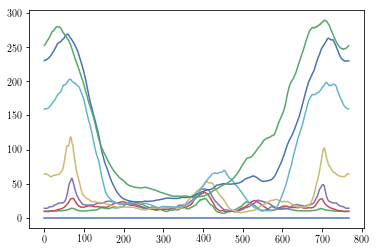

In [32]:
ne_tot_x = np.sum(ne_high_x[:, 2:, :], axis=1)
p1, = plt.plot(ne_tot_x[0])
p1, = plt.plot(ne_tot_x[8])
p1, = plt.plot(ne_tot_x[9])
p2, = plt.plot(ne_tot_x[10])
p2, = plt.plot(ne_tot_x[12])
p3, = plt.plot(ne_tot_x[20])
p4, = plt.plot(ne_tot_x[30])
p5, = plt.plot(ne_tot_x[39])

In [33]:
# High-energy particles close to the boundary
ne_high_xb = []
ntf, nbands, nxr = ne_high_x.shape
xth = 20
for tframe in range(ntf):
    ne_data = ne_high_x[tframe]
    if tframe < 8:
        xth += 0
    elif tframe >= 8:
        t0 = tframe - 8
        xth += int(12 - 0.3 * t0)
#     elif tframe >= 10 and tframe <= 20:
#         xth = (tframe - 15) * 10 + 100
#     else:
#         xth = (tframe - 20) * 2 + 150
#     print(tframe, xth)
    tmp = np.sum(ne_data, axis=1) - np.sum(ne_data[:, xth:-xth], axis=1)
    ne_high_xb.append(tmp)
ne_high_xb = np.asarray(ne_high_xb)

In [34]:
# # High-energy particles close to the boundary (different method)
# ne_high_xb = []
# ntf, nbands, nxr = ne_high_x.shape
# xth1 = xth2 = 20
# for tframe in range(ntf):
#     ne_data = ne_high_x[tframe-1]
#     nsum = np.sum(ne_data[2:, :], axis=0)
#     if tframe < 8:
#         xth1 += 0
#         xth2 += 0
#     elif tframe >= 8:
#         nmax = np.max(nsum)
#         nmin = np.min(nsum)
#         navg = np.mean(nsum)
#         xth1 = np.argmax(nsum < 0.5 * navg)
#         xth2 = np.argmax(nsum[::-1] < 0.5 * navg)
# #         print(xth1, xth2)
#     tmp = np.sum(ne_data, axis=1) - np.sum(ne_data[:, xth1:-xth2], axis=1)
#     ne_high_xb.append(tmp)
# ne_high_xb = np.asarray(ne_high_xb)

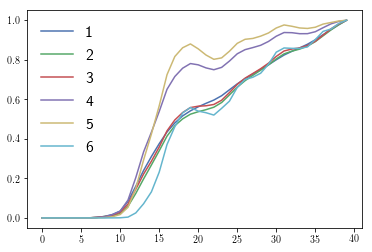

In [35]:
ne_high_ratio = ne_high_xb/ne_high_xb[-1]
for band in range(1, nbands):
    plt.plot(ne_high_ratio[:, band], label=str(band))
leg1 = plt.legend(loc=2, prop={'size': 16}, ncol=1,
                  shadow=False, fancybox=False, frameon=False)

In [36]:
ne_high_tot = np.sum(np.sum(ne_high_x[:, 2:], axis=2), axis=1)

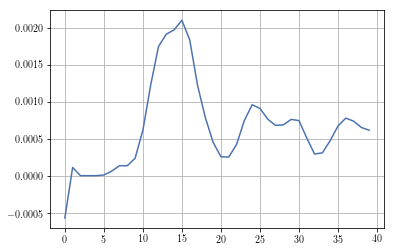

In [37]:
dtf = pic_info.dt_fields * pic_info.dtwpe / pic_info.dtwci
ne_high_ratio20 = np.sum(ne_high_xb[:, 2:], axis=1)
ne_high_acc = ne_high_tot - ne_high_ratio20
esc_rate = np.gradient(ne_high_ratio20, dtf) / ne_high_acc
plt.plot(esc_rate)
plt.grid(True)

In [38]:
# particle acceleration rate
species = 'e'
fpath = '../data/particle_interp/' + pic_run + '/'
falpha = []

for tframe in range(1, 41):
    tindex = pic_info.particle_interval * tframe
    fname = fpath + "particle_energization_" + species + "_" + str(tindex) + ".gda"
    fdata = np.fromfile(fname, dtype=np.float32)
    nbins = int(fdata[0])
    nvar = int(fdata[1])
    ebins = fdata[2:nbins+2]
    fbins = fdata[nbins+2:].reshape((nvar, nbins))
    fbins[1:, :] = div0(fbins[1:, :], fbins[0, :])
    falpha.append(fbins)
falpha = np.asarray(falpha)
ebins /= eth

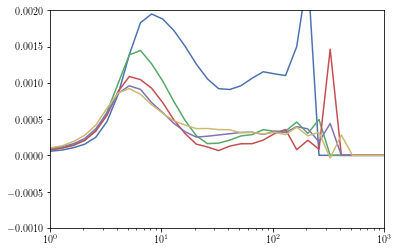

In [54]:
alpha_tot = falpha[:, 1, :] + falpha[:, 2, :]
eindex1, e1 = find_nearest(ebins, 20)
eindex2, e2 = find_nearest(ebins, 200)
p1 = plt.semilogx(ebins, alpha_tot[5:10].T)
l1 = plt.xlim([1, 1E3])
l2 = plt.ylim([-0.001, 0.002])

3.2491505650348738


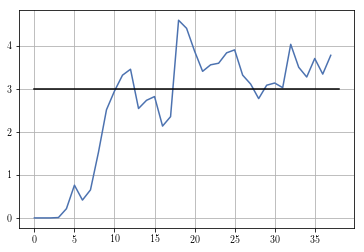

In [49]:
alpha_mean = np.mean(alpha_tot[:, eindex1:eindex2], axis=1)
# ene_tot = np.sum(alpha_tot[:, eindex1:eindex2+1] *
#                  falpha[:, 0, eindex1:eindex2+1], axis=1)
# ntot_high = np.sum(falpha[:, 0, eindex1:eindex2+1], axis=1)
# alpha_mean = ene_tot / ntot_high
pindex = (esc_rate / alpha_mean) * ne_high_acc / ne_high_tot
plt.plot(pindex[2:])
plt.plot([0, 38], [3, 3], color='k')
plt.grid(True)
print(np.mean(pindex[10:]))

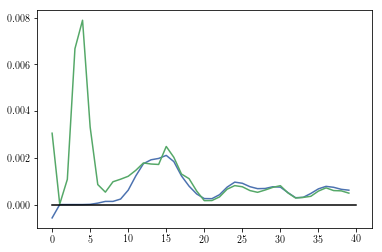

In [56]:
esc_rate[1] = 0
alpha_real = 3.0 * alpha_mean * ne_high_tot / ne_high_acc
p1, = plt.plot(esc_rate)
# p2, = plt.plot(alpha_mean)
p3, = plt.plot(alpha_real)
p4, = plt.plot([0, 40], [0, 0], color='k')